In [15]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// Get the current notebook name (for backup purposes)

<IPython.core.display.Javascript object>

In [16]:
### BACKUP THE CURRENT NOTEBOOK TO S3 ###
### IF THIS FAILS RUN THE CELL ABOVE IT AGAIN ### 
import boto3 
import os 
backup_bucket_name = "backups-final"
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)
nb_full_path = os.path.join(os.getcwd(), nb_name)
s3_client.upload_file(nb_full_path, backup_bucket_name, nb_name)

In [17]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import functions

In [18]:
sql = SQLContext(sc)

In [19]:
data_dir = 's3://geo-final'
out_dir = 's3://cleaned-geo-final'
status_file = data_dir + '/devicestatus.txt'
scrubbed_status_file = data_dir + '/scrubbed_devicestatus3.txt'
clean_latlon_file = out_dir + '/clean_devicestatus3.txt'
d_index = 19 

In [20]:
"""
    This code extracts the required fields and writes it to a new csv in s3
    
    First, the delimeter is determined using a fixed offset index of 19
    Then, split is used to seperate the fields by delimeter,
            we ensure that there are 14 fields as expected
    Next, the data is extracted from indicies 0,1,2,12 and 13
            model and manufacturer must be isolated from index 1.
            This can be done using split, as the manufacturer name 
            is always one word.
    Finally, the data is written to a new file as csv
"""
import smart_open

with smart_open.open(status_file,'r') as fin:
    with smart_open.open(scrubbed_status_file, 'w') as fout:
        for line in fin:
            delimeter = line[d_index]
            comma_sep = line.replace(delimeter, ',')
            split_fields = comma_sep.split(',')
            if len(split_fields) != 14:
                continue
            new_line = []
            date = split_fields[0]
            manufacturer = split_fields[1].split(' ')[0]
            model = ' '.join(split_fields[1].split(' ')[1:])
            deviceID = split_fields[2]
            lat = split_fields[12]
            long = split_fields[13].rstrip('\n')
            
            if float(lat) == 0.0 or float(long) == 0.0:
                continue
            
            new_line.append(lat)
            new_line.append(long)
            new_line.append(date)
            new_line.append(deviceID)
            new_line.append(manufacturer)
            new_line.append(model)

            scrubbed = ','.join(new_line)
            fout.write(scrubbed + '\n')

In [21]:
from pyspark.sql.types import *

status_df_schema = StructType(
  [StructField('Latitude', DoubleType()),
   StructField('Longitude', DoubleType()),
   StructField('date', DateType()),
   StructField('deviceID', StringType()),
   StructField('manufacturer', StringType()),
   StructField('model', StringType())]
)


In [22]:
status_df = sql.read.format('csv')\
                            .options(header=False, inferSchema=False)\
                            .schema(status_df_schema)\
                            .load(scrubbed_status_file)


In [23]:
status_df.show()

+-------------+--------------+----------+--------------------+------------+--------------+
|     Latitude|     Longitude|      date|            deviceID|manufacturer|         model|
+-------------+--------------+----------+--------------------+------------+--------------+
|33.6894754264|-117.543308253|2014-03-15|8cc3b47e-bd01-448...|    Sorrento|          F41L|
|37.4321088904|-121.485029632|2014-03-15|ef8c7564-0a1a-465...|      MeeToo|           1.0|
|39.4378908349|-120.938978486|2014-03-15|23eba027-b95a-472...|      MeeToo|           1.0|
|39.3635186767|-119.400334708|2014-03-15|707daba1-5640-4d6...|    Sorrento|          F41L|
|33.1913581092|-116.448242643|2014-03-15|db66fe81-aa55-43b...|       Ronin|Novelty Note 1|
|33.8343543748|-117.330000857|2014-03-15|ffa18088-69a0-433...|    Sorrento|          F41L|
|37.3803954321|-121.840756755|2014-03-15|66d678e6-9c87-48d...|    Sorrento|          F33L|
|34.1841062345|  -117.9435329|2014-03-15|673f7e4b-d52b-44f...|      MeeToo|           4.1|

##### We want just the lat lon for the rest of the project

In [24]:
latlon_df = status_df.select('Latitude', 'Longitude')
latlon_df.show()

+-------------+--------------+
|     Latitude|     Longitude|
+-------------+--------------+
|33.6894754264|-117.543308253|
|37.4321088904|-121.485029632|
|39.4378908349|-120.938978486|
|39.3635186767|-119.400334708|
|33.1913581092|-116.448242643|
|33.8343543748|-117.330000857|
|37.3803954321|-121.840756755|
|34.1841062345|  -117.9435329|
|32.2850556785|-111.819583734|
|45.2400522984|-122.377467861|
|37.9248961741|-122.206868167|
|38.1653163975|-122.151608378|
| 33.323126641|-116.472234745|
|33.1774985363|-116.889226299|
|32.2083493316|-111.434102713|
|34.0487620041|-111.928871717|
|37.9031053656|-121.561451342|
| 36.032967794|-118.970108886|
|45.0400810371|-117.858004521|
|35.2338863976|  -114.3057523|
+-------------+--------------+
only showing top 20 rows



In [25]:
latlon_df.write.csv(clean_latlon_file)

In [26]:
from shapely.geometry import Point
import geopandas as gpd
df = status_df.toPandas()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))

In [27]:
gdf.head()

,Latitude,Longitude,date,deviceID,manufacturer,model,geometry
0,33.689475,-117.543308,2014-03-15,8cc3b47e-bd01-4482-b500-28f2342679af,Sorrento,F41L,POINT (-117.54331 33.68948)
1,37.432109,-121.485030,2014-03-15,ef8c7564-0a1a-4650-a655-c8bbd5f8f943,MeeToo,1.0,POINT (-121.48503 37.43211)
2,39.437891,-120.938978,2014-03-15,23eba027-b95a-4729-9a4b-a3cca51c5548,MeeToo,1.0,POINT (-120.93898 39.43789)
3,39.363519,-119.400335,2014-03-15,707daba1-5640-4d60-a6d9-1d6fa0645be0,Sorrento,F41L,POINT (-119.40033 39.36352)
4,33.191358,-116.448243,2014-03-15,db66fe81-aa55-43b4-9418-fc6e7a00f891,Ronin,Novelty Note 1,POINT (-116.44824 33.19136)


<AxesSubplot:>

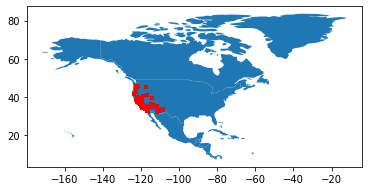

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot()
gdf.plot(ax=ax,color='red',markersize=0.5)